In [1]:
import numpy as np
import nilearn.plotting as niplot
import matplotlib.pyplot as plt
import glob
import nilearn
from nibabel import load
plt.rcParams.update({'font.size': 18})

Bad val 'white' on line #20
	"grid.linewidth: white
"
	in file "/home/mboos/.config/matplotlib/stylelib/mb.mplstyle"
	Key grid.linewidth: Could not convert "white" to float


In [2]:
maps = glob.glob('scores_subj*.nii.gz')
scores_bsc = [load(map_i).get_data() for map_i in maps]

In [3]:
mean_scores = np.mean(np.concatenate([score[None] for score in scores_bsc], axis=0), axis=0)
average_score = nilearn.image.new_img_like(maps[0], mean_scores)

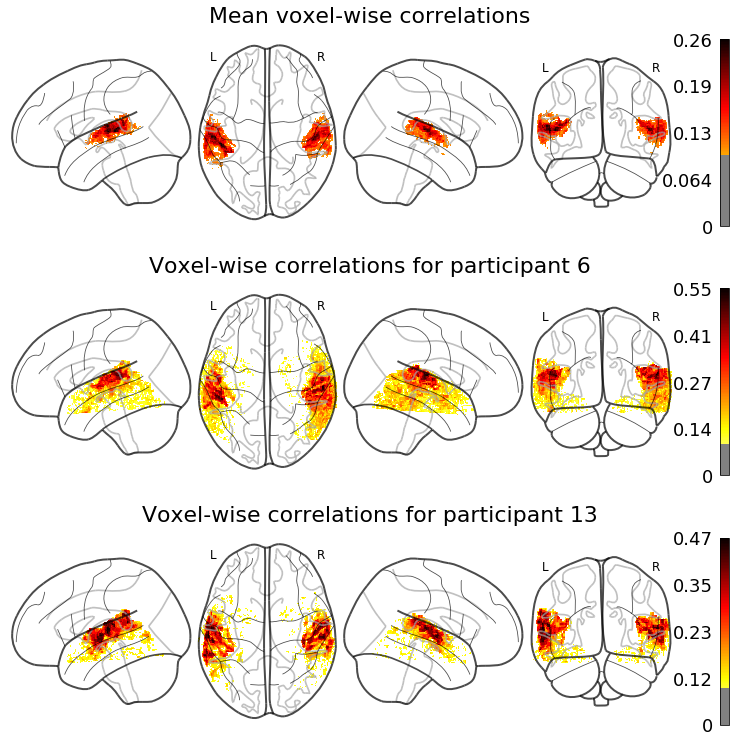

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(13, 13))
niplot.plot_glass_brain(average_score, threshold=0.1, colorbar=True, axes=axes[0], display_mode='lzry')
axes[0].set_title(r'Mean voxel-wise correlations', fontsize=22)
niplot.plot_glass_brain(maps[10], threshold=0.1, colorbar=True, axes=axes[1], display_mode='lzry')
axes[1].set_title(r'Voxel-wise correlations for participant 6', fontsize=22)
niplot.plot_glass_brain(maps[5], threshold=0.1, colorbar=True, axes=axes[2], display_mode='lzry')
axes[2].set_title(r'Voxel-wise correlations for participant 13', fontsize=22)
fig.savefig('glassbrain_example.pdf')

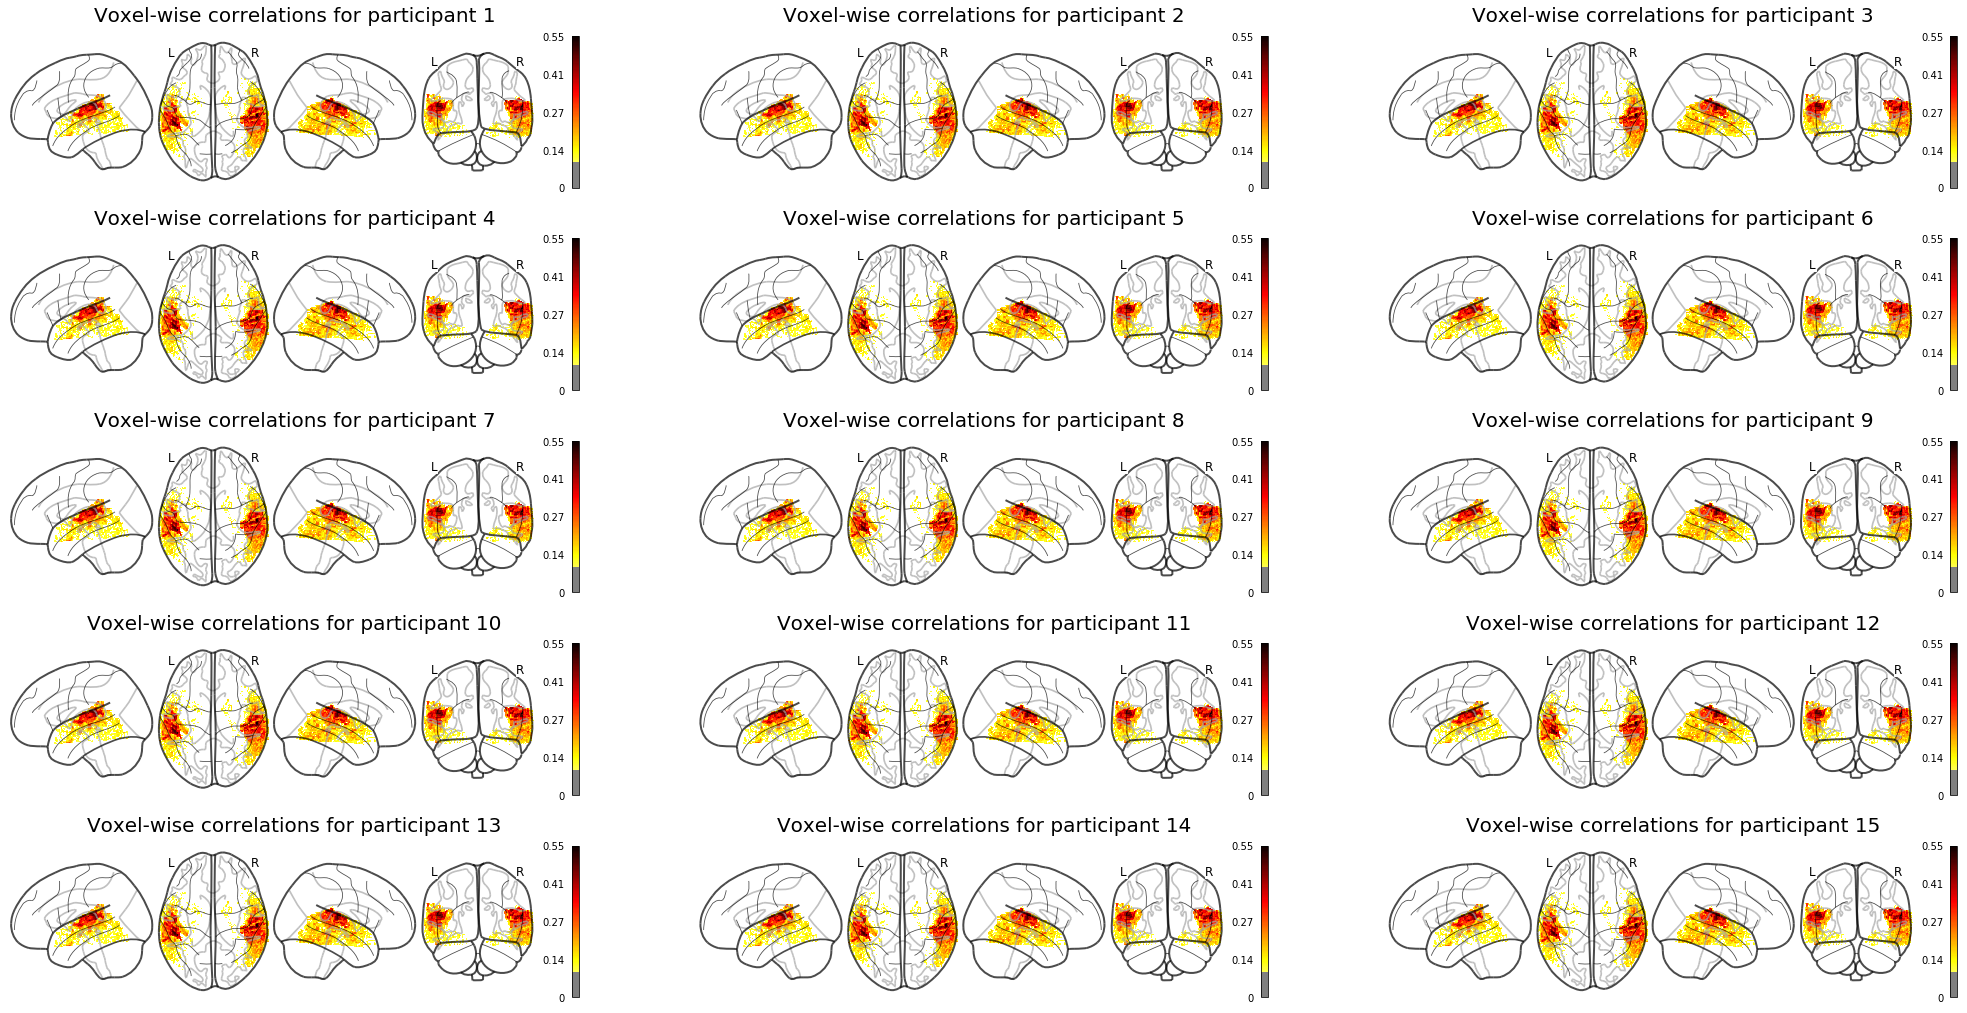

In [4]:
fig, axes = plt.subplots(5, 3, figsize=(35, 18))
axes = axes.flatten()
for i, ax in enumerate(axes):
    niplot.plot_glass_brain(maps[10], threshold=0.1, colorbar=True, axes=axes[i], display_mode='lzry')
    axes[i].set_title(r'Voxel-wise correlations for participant {}'.format(i+1), fontsize=20)
#plt.tight_layout()
fig.savefig('glassbrains.pdf')

# Comparing MFS with BSC scores

In [5]:
subjects = [1,2,5,6,7,8,9,11,12,14,15,16,17,18,19]
mfs_maps = ['mfs_subj_{}.nii.gz'.format(subj) for subj in subjects]
mfs_scores = [load(map_i).get_data() for map_i in mfs_maps]

In [6]:
import joblib
scores = {'bsc': joblib.load('scores_new_ridge.pkl'),'mfs': joblib.load('scores_mfs.pkl')}

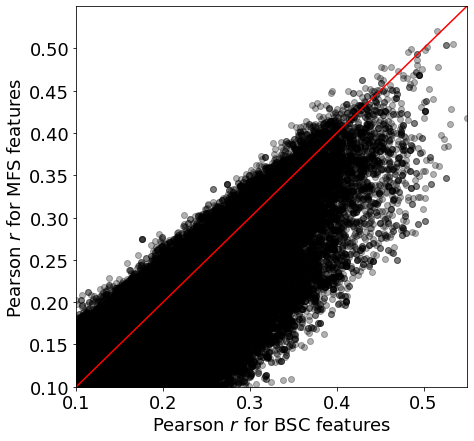

In [4]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, figsize=(7,7))
for i in range(15):
    sig_scores = np.logical_and(scores['bsc'][i]>0.1, scores['mfs'][i]>0.1)
    ax.scatter(scores['bsc'][i][sig_scores], scores['mfs'][i][sig_scores], alpha=0.3, color='k')
xmin,xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
imin, imax = min(xmin, ymin), max(np.max(scores['bsc']), np.max(scores['mfs']))
ax.set_xlim(0.1, imax)
ax.set_ylim(0.1, imax)
ax.plot([0.1, imax], [0.1, imax], color='r')
ax.set_xlabel(r'Pearson $r$ for BSC features')
ax.set_ylabel(r'Pearson $r$ for MFS features')
fig.savefig('Correlations_mfs_bsc.png', bbox_inches='tight')

In [7]:
from nilearn import datasets
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')

In [11]:
atlas_filename = dataset.maps
labels = dataset.labels

In [46]:
len(dataset.labels)

49

In [8]:
regions = [
 'Superior Temporal Gyrus, anterior division',
 'Superior Temporal Gyrus, posterior division',
 "Heschl's Gyrus (includes H1 and H2)",
 'Planum Temporale']
regions_int = [np.where([lbl==reg for lbl in dataset.labels])[0][0]
               for reg in regions]
regions = ['STG, anterior',
          'STG, posterior',
          "Heschl's Gyrus",
          'Planum Temporale']

In [12]:
from collections import defaultdict
map_idx = load(atlas_filename).get_data()
scores_reg_dict = {'bsc': defaultdict(list), 'mfs': defaultdict(list)}
for reg, i in zip(regions, regions_int):
    map_is = map_idx == i
    for sub in range(15):
        arr_bsc = scores_bsc[sub][map_idx==i]
        arr_mfs = mfs_scores[sub][map_idx==i]
        scores_reg_dict['bsc'][reg].append(arr_bsc[arr_bsc>0.1])
        scores_reg_dict['mfs'][reg].append(arr_mfs[arr_mfs>0.1])
    scores_reg_dict['bsc'][reg] = np.concatenate(scores_reg_dict['bsc'][reg])
    scores_reg_dict['mfs'][reg] = np.concatenate(scores_reg_dict['mfs'][reg])

In [13]:
import pandas as pd
ft_idx, reg_idx, arr = map(np.concatenate, zip(*[([ft]*arr.shape[0], [reg]*arr.shape[0], arr) for ft, ft_dict in scores_reg_dict.items()
                                                 for reg, arr in ft_dict.items()]))
df = pd.DataFrame({'Feature': ft_idx, 'Region': reg_idx, r'Pearson $r$': arr})

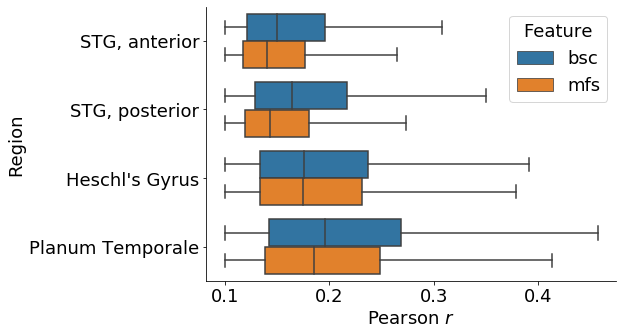

In [13]:
import seaborn as sns
g=sns.catplot(data=df, x=r'Pearson $r$', kind='box', y='Region', hue='Feature', legend_out=False, showfliers=False)
g.fig.set_figwidth(9)
plt.tight_layout()
g.fig.savefig('mfs_bsc_region_diff.svg')

In [17]:
from scipy.stats import ttest_ind
tval_dict = {}
mean_diff_dict = {}
for reg, reg_df in df.groupby('Region'):
    tval_dict[reg] = ttest_ind(reg_df[r'Pearson $r$'][reg_df['Feature']=='bsc'], reg_df[r'Pearson $r$'][reg_df['Feature']=='mfs'])
    mean_diff_dict[reg] = reg_df[r'Pearson $r$'][reg_df['Feature']=='bsc'].mean()-reg_df[r'Pearson $r$'][reg_df['Feature']=='mfs'].mean()

In [25]:
tval_dict["Heschl\'s Gyrus"][1]

1.1735135652682446e-07

In [27]:
1.1735135652682446e-07<0.0001

True

In [20]:
mean_diff_dict["Heschl\'s Gyrus"], tval_dict["Heschl\'s Gyrus"]

(0.0033112168,
 Ttest_indResult(statistic=5.298278964124158, pvalue=1.1735135652682446e-07))

In [21]:
mean_diff_dict['Planum Temporale'], tval_dict['Planum Temporale']

(0.013255522,
 Ttest_indResult(statistic=26.034542037754527, pvalue=6.321980636341931e-149))

In [22]:
mean_diff_dict['STG, anterior'], tval_dict['STG, anterior']

(0.013047755,
 Ttest_indResult(statistic=20.02915712831371, pvalue=1.234881471200303e-88))

In [23]:
mean_diff_dict['STG, posterior'], tval_dict['STG, posterior']

(0.024989873, Ttest_indResult(statistic=48.33094069818544, pvalue=0.0))

In [140]:
explained_var = joblib.load('expl_var.pkl')

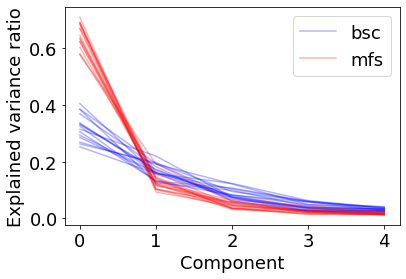

In [148]:
fig, ax = plt.subplots(1,1)
for i in range(15):
    if i == 0:
        ax.plot(explained_var['bsc'][i], label='bsc', color='b', alpha=0.3)
        ax.plot(explained_var['mfs'][i], label='mfs', color='r', alpha=0.3)
    else:
        ax.plot(explained_var['bsc'][i], color='b', alpha=0.3)
        ax.plot(explained_var['mfs'][i], color='r', alpha=0.3)
ax.set_xlabel('Component')
ax.set_ylabel('Explained variance ratio')
plt.legend()
fig.savefig('explained_variance.svg')